**Metro Digital Hiring Assignment**

*Matan Prasma*

In this notebook we present a Collaborative Filtering model that is applied on a user-item dataset in order to recommend items for existing and potentially new users. 
From the initial dataset one constructs a user-item interaction matrix I of size MxN where M is the number of users and N is the number of items. Our Collaborative Filtering model aims to approximate a decomposition I = UV^T where U is a 'user embedding' matrix of size MxK and V is an 'item embedding' matrix of size NxK. We refer to K as the embedding dimension and aim to approximate such a decomposition by minimising the mean squared error.  
As requested, the implementation is given in Tensorflow and follows a standard train and evaluation procedure.

Table of contents:

*   Exploratory Data Analysis
*   Data Preprocessing
*   Model Building
*   Training and Evaluating the Model
*   Visualize the Embedding Vectors





In [1]:
#!pip install --upgrade tensorflow==1.14
# note we use tensorflow 1 in this notebook.
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import collections
from matplotlib import pyplot as plt
from google.colab import drive

print(tf.__version__)

drive.mount('/content/drive')



/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

1.14.0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Exploratory data analysis**

In [2]:
df = pd.read_csv('/content/drive/MyDrive/metro_digital/data/transactions_sample.csv')

# add a rating column filled with 1's for a later matrix representation 
df['rating'] = np.ones(len(df))

# count number of users and items
NUSERS = df['customer_uuid'].nunique()
NITEMS = df['product_uuid'].nunique()
print("There are {} unique users and {} unique items".format(NUSERS,NITEMS))
df.head()

There are 4760 unique users and 3188 unique items


,customer_uuid,product_uuid,product_category,rating
0,84941cf9-d19d-4c1d-b180-845e36a931b0,03058102-487d-4424-b984-23453dda75a2,tea -- fruit,1.0
1,3ad4d182-e1d6-4052-8a65-6b7cbe817027,03058102-487d-4424-b984-23453dda75a2,tea -- fruit,1.0
2,b1a61ad5-7569-424f-83ff-d9305acd3a21,03058102-487d-4424-b984-23453dda75a2,tea -- fruit,1.0
3,f0e551d9-186a-42d9-bfdd-6ea6e17966f6,03058102-487d-4424-b984-23453dda75a2,tea -- fruit,1.0
4,8ba6db5a-eab7-4650-a821-a95c6b70ae66,03058102-487d-4424-b984-23453dda75a2,tea -- fruit,1.0


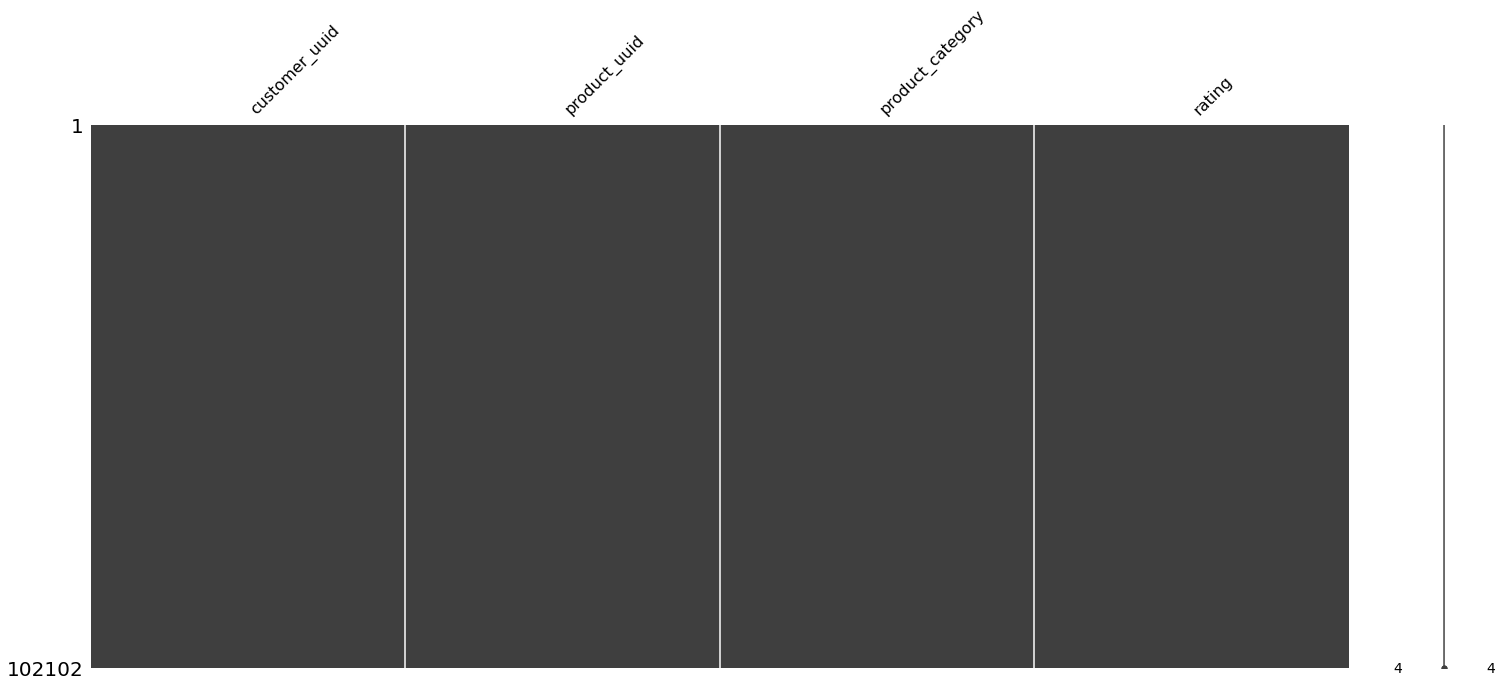

In [3]:
# check for missing values 
import missingno as msno
msno.matrix(df)

#...no missing values found

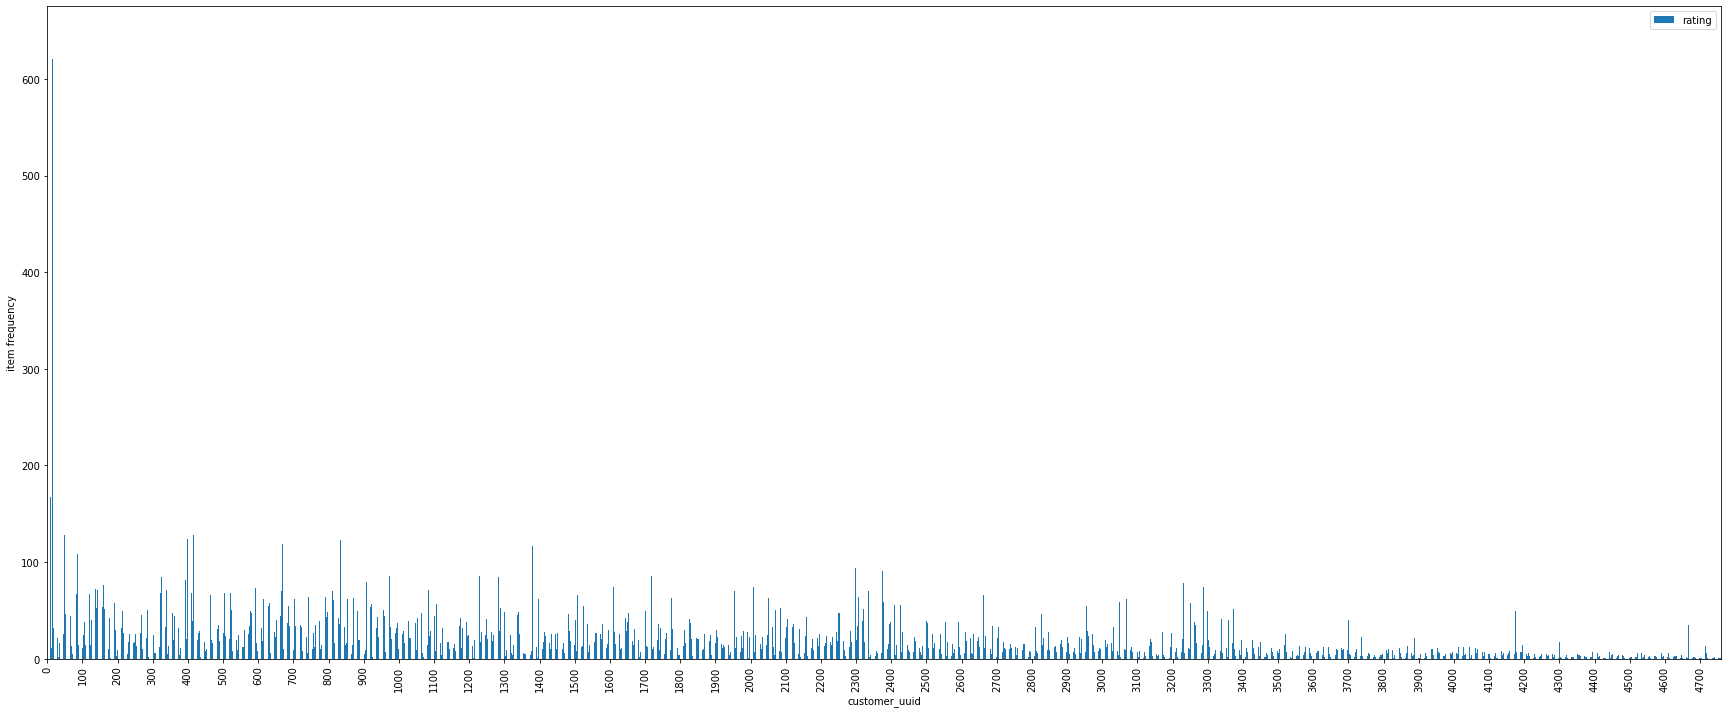

In [4]:
# display the distribution of items per user

df.assign(customer_uuid=lambda d: pd.factorize(d['customer_uuid'])[0]).groupby('customer_uuid').agg({'rating': sum}).plot(kind='bar', figsize=(30, 12))
plt.xticks(range(0,NUSERS,100), range(0,NUSERS,100))
plt.ylabel('item frequency')
plt.show()

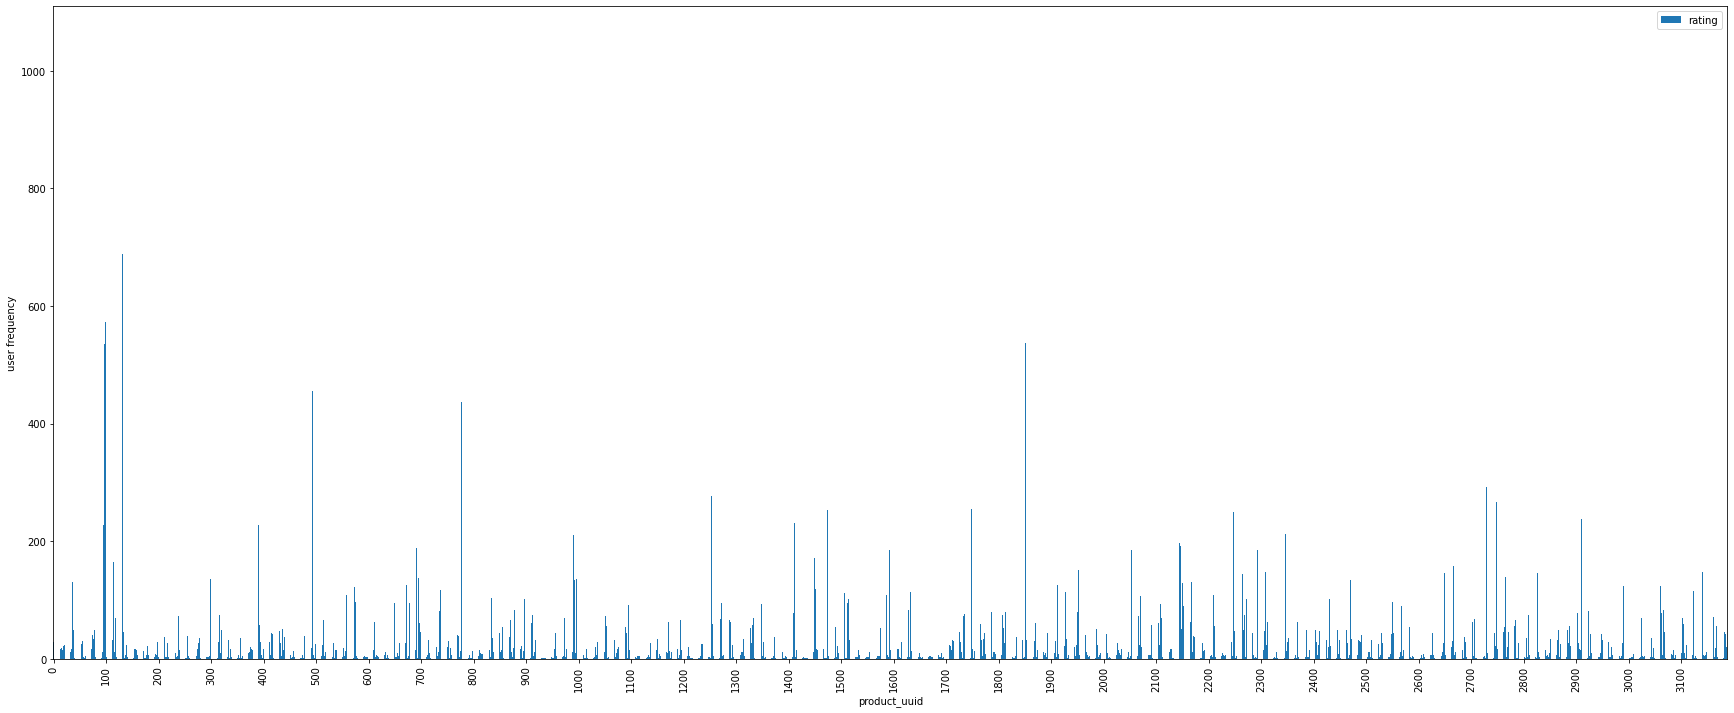

In [5]:
# display the distribution of users per item

df.assign(product_uuid=lambda d: pd.factorize(d['product_uuid'])[0]).groupby('product_uuid').agg({'rating': sum}).plot(kind='bar', figsize=(30, 12))
plt.xticks(range(0,NITEMS,100), range(0,NITEMS, 100))
plt.ylabel('user frequency')
plt.show()

In [6]:
# stats of the data 

df[['customer_uuid','product_uuid','product_category']].describe()

,customer_uuid,product_uuid,product_category
count,102102,102102,102102
unique,4760,3188,574
top,2d0808e6-1f01-44d4-afa8-162dc7b6d50e,d01eebe3-d41a-4dca-b970-60d8fe9d1bf4,cigarettes/tobacco/cigars -- cigarettes
freq,643,1057,3530


**`Data preprocessing`**

In [7]:
# we want to convert the user and item id's to integers in order to input it to our Matrix Factorisation model

def create_mapping(values):
  """Creates a dictionary from a pandas series and saves it to disk.
  Args:
    values: a pandas series.
  Returns:
    value_to_id: dictionary that maps values to integers
  """

  value_to_id = {value:idx for idx, value in enumerate(values.unique())}

  return value_to_id



In [8]:
user_mapping = create_mapping(df["customer_uuid"])
item_mapping = create_mapping(df["product_uuid"])

df["userId"] = df["customer_uuid"].map(user_mapping.get)
df["itemId"] = df["product_uuid"].map(item_mapping.get)

# We will use mapped_df as our input dataframe. To distinguish between original customer and product id's and the integers 
# we converted them to, we rename these to "userId" and "itemId".  
mapped_df = df[["userId", "itemId", "rating"]]

mapped_df.head()

,userId,itemId,rating
0,0,0,1.0
1,1,0,1.0
2,2,0,1.0
3,3,0,1.0
4,4,0,1.0


In [9]:
# we present the most popular items bought by users. This will later be used for a sanity check of our recommendation model.

k=100

topItems = list(df.groupby('itemId', as_index=False).agg({'rating': sum}).sort_values('rating', ascending = False).head(k).index)
df.groupby('itemId', as_index=False).agg({'rating': sum}).sort_values('rating', ascending = False).head(k)


,itemId,rating
207,207,1057.0
1136,1136,1005.0
1478,1478,728.0
131,131,689.0
1485,1485,573.0
...,...,...
1088,1088,174.0
2848,2848,174.0
2543,2543,174.0
1728,1728,172.0


In [10]:
# This function will split a dataframe into train and test dataframes. 
# As remarked in a correspondense with Christopher, evaluating a Matrix Factorisation model in this way may not be the best way 
# but we follow the assignment guidlines here.

def split_dataframe(df, test_fraction=0.1):
  """Splits a DataFrame into training and test sets.
  Args:
    df: a dataframe.
    test_fraction: fraction of dataframe rows to use in the test set.
  Returns:
    train: dataframe for training
    test: dataframe for testing
  """
  test = df.sample(frac=test_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

**Model building**

In [11]:
# The user-item interaction matrix is quite large so we'll need to store it in a Sparse Tensor.

def build_rating_sparse_tensor(df, nusers, nitems):
  """
  Args:
    df: a pd.DataFrame with `userId`, `itemId` and `rating` columns.
    nusers: number of users
    nitems: number of items
  Returns:
    a tf.SparseTensor representing the user-item interaction matrix.
  """
  indices = df[['userId', 'itemId']].values
  values = df['rating'].values
  return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[nusers,nitems])

In [12]:
# Given a decomposition of the user-item interaction matrix (in terms of two sparse tensor matrices), we would like to evaluate the MSE.

def sparse_mean_square_error(sparse_ratings, user_embeddings, item_embeddings):
  """
  Args:
    sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
    user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
      dimension, such that U_i is the embedding of user i.
    item_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
      dimension, such that V_j is the embedding of item j.
  Returns:
    A scalar Tensor representing the MSE between the true ratings and the
      model's predictions.
  """
  predictions = tf.gather_nd(
      tf.matmul(user_embeddings, item_embeddings, transpose_b=True),
      sparse_ratings.indices)
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss

In [13]:
# For convinience and with an eye toward productionalization, we define a class for a Collaborative Filtering Model.

class CFModel(object):
  """A simple class that represents a collaborative filtering model"""
  def __init__(self, embedding_vars, loss, metrics=None, session=None):
    """Initializes a CFModel.
    Args:
      embedding_vars: A dictionary of items of the form (string,tf.Variable) representing the user and item embedding.
      loss: A float Tensor. The loss to optimize.
      metrics: optional dictionary of items of the form (string, Tensor). The metrics in each
        item will be plotted in a separate graph during training.
    """
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = session

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    """Trains the model.
    Args:
      num_iterations: number of iterations to run.
      learning_rate: optimizer learning rate.
      plot_results: whether to plot the results at the end of training.
      optimizer: the optimizer to use. Default to GradientDescentOptimizer.
    Returns:
      The metrics dictionary evaluated at the last iteration.
    """
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.variables_initializer(opt.variables())
      if self._session is None: # in case a user wants to continue a run of an existing session
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())

    with self._session.as_default():
      self._session.run(local_init_op)
      iterations = [] # intended to be the x-axis of the results plot
      metrics = self._metrics 
      metrics_vals = collections.defaultdict(list) # recall that collections.defaultdict(list) is a dictionary whose values are lists
      # here we intend to store the values of the metrics evaluated during training for future plotting.
      
      # Train and append results.
      for i in range(1,num_iterations+1):
        _ = self._session.run(train_op)
        results = self._session.run(metrics) # results is a dictinary corresponding to that of metrics, with the tensors evaluated
        if (i % 10 == 1) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for k, v in results.items()]),
                end='')
          iterations.append(i)
          for k, v in results.items():
            metrics_vals[k].append(v)
      # we store the values of U and V after training is done.
      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        fig = plt.figure()
        fig.set_size_inches(20, 8)
        for k,v in metrics_vals.items():
          ax = fig.add_subplot(1,2,1)
          ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

In [14]:
def build_model(nusers, nitems, mapped_df, embedding_dim=10, init_stddev=1.):
  """
  Args:
    nusers: number of users.
    nitems: number of items.
    mapped_df: a DataFrame of the ratings where users and items are enumerated with integers.
    embedding_dim: the dimension of the embedding vectors.
    init_stddev: float, the standard deviation of the random initial embeddings.
  Returns:
    model: a CFModel.
  """
  # Split the ratings DataFrame into train and test.
  train_df, test_df = split_dataframe(mapped_df)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_df, nusers, nitems)
  A_test = build_rating_sparse_tensor(test_df, nusers, nitems)
  # Initialize the embeddings using a normal distribution.
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
  train_loss = sparse_mean_square_error(A_train, U, V)
  test_loss = sparse_mean_square_error(A_test, U, V)
  metrics = {
      'train_error': train_loss,
      'test_error': test_loss
  }
  embeddings = {
      "user": U,
      "item": V
  }
  return CFModel(embeddings, train_loss, metrics)

**Trainingg and Evaluating the Model**

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
 iteration 5000: train_error=0.053044, test_error=0.124726

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


{'test_error': 0.124726474, 'train_error': 0.05304444}

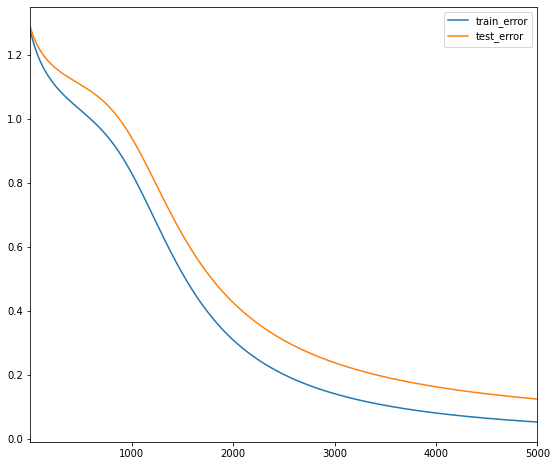

In [15]:
model = build_model( NUSERS, NITEMS, mapped_df, embedding_dim=5, init_stddev=0.5)
model.train(num_iterations=5000, learning_rate=2.)

In [16]:
# Here we compute the scores for a given user and in order to decide on recommendations.
# For additional felxibility, we have an option of computing either dot product of cosine similarity.

def compute_scores(query_embedding, item_embeddings, measure = 'DOT PRODUCT'):
  """Computes the scores of the candidates given a query.
  Args:
    query_embedding: a vector of shape [K], representing a user in the user embedding matrix.
    item_embeddings: a matrix of shape [N, K], such that row i is the embedding
      of item i.
  Returns:
    scores: a vector of shape [N], such that scores[i] is the score of item i.
  """
  u = query_embedding
  V = item_embeddings
  if measure == 'COSINE': # in case we compute cosine similarity we simply normalise the vectors.
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)

  return scores

In [17]:
def user_recommendations(mapped_df, model, userId, measure= 'DOT PRODUCT', k=10, exclude_rated=True):
  """ Collects the recommended items for a user based on socres.
  Args:
    mapped_df: dataframe for user-item ratings after userId's and itemId's are mapped to integers.
    model: the Matrix Factorisation Model (a CFMODEL instance).
    userId: the user Id for which the recommendation is requested.
    measure: score measure for recommendation.
    k: number of most recommended items.
    exclude_rated: remove recommende items that were already rated by the user.
  Returns:
    df: a dataframe of length k whose indicies are the recommended items (sorted) for the input user together with their 
    corresponding score.
  """
  assert 0<=userId<NUSERS, "User does not exist"

  scores = compute_scores(
      model._embeddings["user"][userId], model._embeddings["item"], measure)
  
  score_key = measure +' SCORE'
  df = pd.DataFrame(
      columns = [score_key], data = list(scores)
    )
  if exclude_rated:
    # remove items that are already rated
    df_user = mapped_df[mapped_df['userId']== userId]
    rated_items = df_user['itemId'].unique()
    df = df.iloc[rated_items]
  return df

In [18]:
USER = 0
MEASURE = 'DOT PRODUCT'
k=100
df_rec = user_recommendations(mapped_df, model,USER, MEASURE, k)
recommendations = df_rec.sort_values([MEASURE+' SCORE'], ascending=False).head(k)

recommendations.head(10)

,DOT PRODUCT SCORE
938,1.187378
816,1.140098
2877,1.138751
2457,1.123708
2601,1.119468
2364,1.116287
2745,1.113773
262,1.113645
1235,1.110759
1606,1.110306


In [19]:
inverse_item_mapping = dict((v, k) for k, v in item_mapping.items())

print("Top {} recommendations for user {} are: \n {}".format(10,USER, list(recommendations.index)[:10] ))
print("Top {} recommendations for user {} in original 'product_uuid' are: \n {}".format(10,USER, '\n'.join(list(recommendations.index[:10].map(inverse_item_mapping.get)))))

Top 10 recommendations for user 0 are: 
 [938, 816, 2877, 2457, 2601, 2364, 2745, 262, 1235, 1606]
Top 10 recommendations for user 0 in original 'product_uuid' are: 
 a5205b59-8e09-4881-b701-dfb40e06e46a
8fd4451f-9477-4a57-b38c-35028397c978
4f0960d2-ba33-43a2-8205-503fc37fbad3
960d5b9a-6788-462c-9c8b-b804b366a012
60c338d2-eee2-4fc2-896b-2548f8b4ce9b
ed2fa97c-99ae-48a5-99e8-bc1f5e310e23
dddd2d33-2aa2-4c85-acbc-79db46b143d4
18dda19f-009f-4625-87a1-d506eaca4631
272e7eb8-5bc8-4d0b-a57c-5d336b8c7ee3
ecb782c1-200d-4e51-88df-179f9bc00775


In [20]:
# Sanity check: let's see that the recommendations for user 0 include some popular items among all users.

print("The following items are in the top {} recommended items for user {} and also appear in the {} most popular items among all users".format(k,USER, k))

for item in list(recommendations.index):
  if item in topItems:
    print(item)

The following items are in the top 100 recommended items for user 0 and also appear in the 100 most popular items among all users
2848
2204
2910
1416
2729
2258
1035
675
1136
1851
2850
2865
136
582
623
2146
1411
734
704
541
2346
129
2120
2102
498
2860
1172
1759
580
2263
1993
390
205
1252
2796
1504
2053
1749


**Visualize the Embedding Vectors**

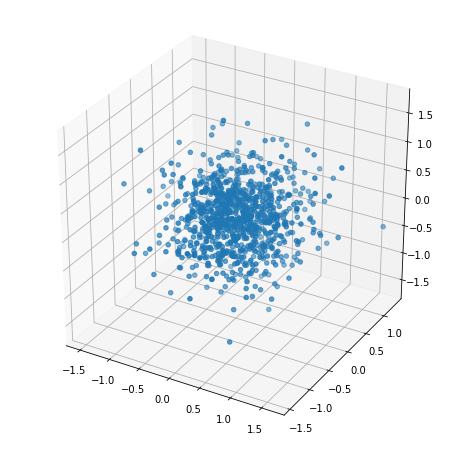

In [21]:
# Here we display the user embedding vectors after PCH

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

user_embeddings = list(model._embeddings['user'])

pca = PCA(n_components = 3)
pca.fit(user_embeddings)
user_embeddings_pca = pca.transform(user_embeddings)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection = "3d")
xs, ys, zs = user_embeddings_pca[::5].T
ax.scatter(xs, ys, zs)